In [1]:
%matplotlib inline 
#%load_ext autoreload 
%reload_ext autoreload
%autoreload 2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel


import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)


import sys
sys.path.append('/Users/RAJ/github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap
import statsmodels.api as sm
from scipy.interpolate import interp1d 
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools

import sep
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap

/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/RAJ/anaconda/envs/illustris_profiles/lib/python2.7/site-packages/pyraf/irafimport.py:116: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  retval = _originalImport(name, globals, locals, fromlist, level)


In [2]:
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single

In [3]:
x_images = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf/bin.macosx/x_images.e'
TBL = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/tables/bin.macosx/x_ttools.e'
ISO = '/Users/RAJ/anaconda/envs/illustris_profiles/iraf_extern/stsdas/bin.macosx/x_isophote.e'

In [4]:
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

In [9]:
illustris_direc_metal = '/Users/RAJ/summer_work_2018/notebook_tng/high_res/metal'
illustris_direc_age = '/Users/RAJ/summer_work_2018/notebook_tng/high_res/age'

In [6]:
illustris_high_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/high_res/galaxies_tng100_072_agez_highres.hdf5'
illustris_quick_file_hdf5='/Users/RAJ/summer_work_2018/notebook_tng/quick/galaxies_tng100_072_agez_lowres.hdf5'

In [7]:
def get_metallicity_maps(sim_file,direc):

    f = h5py.File(sim_file, 'r')
    n_galaxies = len(f['catsh_id'])
    cen_insitu = np.array(f['map_star_metallicity_insitu_xy'])
    cen_exsitu = np.array(f['map_star_metallicity_exsitu_xy'])
    map_stars_cen = cen_exsitu + cen_insitu 
    map_size = f['config'].attrs['map_range_min']
    n_pixels = f['config'].attrs['map_npixel']
    pixel_scale=2 * (map_size/n_pixels)
    f.close()
    Illustris_maps = []
    
    for gal_n in range(n_galaxies):
        img_cen = map_stars_cen[gal_n] # Central
        img_ins = cen_insitu[gal_n]
        img_exs = cen_exsitu[gal_n] 
        prefix = 'illustris_%s' % str(gal_n).strip()
        
        
        # Central only 
        cen_fits = os.path.join(direc, prefix + "_cen.fits" )
        _ = io.save_to_fits(img_cen, cen_fits)

        # In-situ stars
        ins_fits = os.path.join(direc, prefix + "_ins.fits")
        _ = io.save_to_fits(img_ins, ins_fits)

        # Ex-situ stars
        exs_fits = os.path.join(direc, prefix + "_exs.fits" )
        _ = io.save_to_fits(img_exs, exs_fits)

        Illustris_maps.append(np.stack([img_cen, img_ins, img_exs, ]))
    
    return Illustris_maps

In [8]:
def get_age_maps(sim_file,direc):

    f = h5py.File(sim_file, 'r')
    n_galaxies = len(f['catsh_id'])
    cen_insitu = np.array(f['map_star_age_insitu_xy'])
    cen_exsitu = np.array(f['map_star_age_exsitu_xy'])
    map_stars_cen = cen_exsitu + cen_insitu 
    map_size = f['config'].attrs['map_range_min']
    n_pixels = f['config'].attrs['map_npixel']
    pixel_scale=2 * (map_size/n_pixels)
    f.close()
    Illustris_maps = []
    
    for gal_n in range(n_galaxies):
        img_cen = map_stars_cen[gal_n]  # Central
        img_ins = cen_insitu[gal_n]
        img_exs = cen_exsitu[gal_n] 
        prefix = 'illustris_%s' % str(gal_n).strip()
        
        
        # Central only 
        cen_fits = os.path.join(direc, prefix + "_cen.fits" )
        _ = io.save_to_fits(img_cen, cen_fits)

        # In-situ stars
        ins_fits = os.path.join(direc, prefix + "_ins.fits")
        _ = io.save_to_fits(img_ins, ins_fits)

        # Ex-situ stars
        exs_fits = os.path.join(direc, prefix + "_exs.fits" )
        _ = io.save_to_fits(img_exs, exs_fits)

        Illustris_maps.append(np.stack([img_cen, img_ins, img_exs, ]))
    
    return Illustris_maps

In [10]:
Illustris_maps_high_metal = get_metallicity_maps(illustris_high_file_hdf5, illustris_direc_metal)
Illustris_maps_high_age = get_age_maps(illustris_high_file_hdf5, illustris_direc_age)

In [12]:
np.save(os.path.join(illustris_direc_metal, 'Illustris_maps_high_metal.npy'), np.asarray(Illustris_maps_high_metal))
np.save(os.path.join(illustris_direc_age, 'Illustris_maps_high_age.npy'), np.asarray(Illustris_maps_high_age))

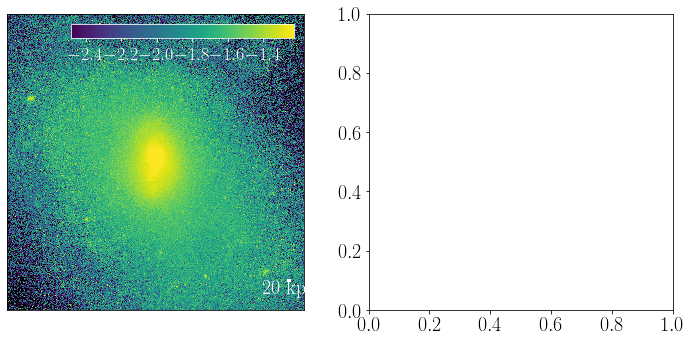

In [28]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
#ax3 = plt.subplot(2, 2, 3)



display_single(Illustris_maps_high_metal[0][0], ax=ax1, contrast=0.50,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=11.0,
                         physical_scale=20.0,
                         color_bar=True)


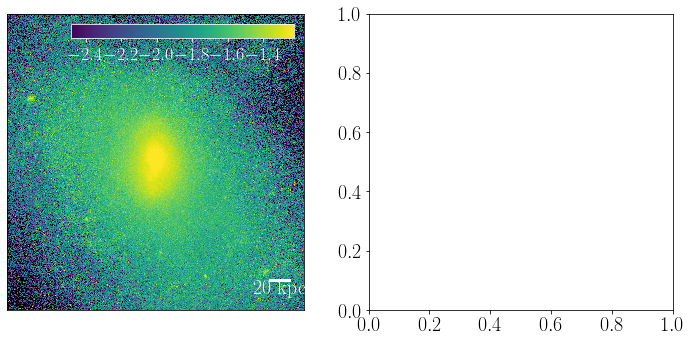

In [29]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
#ax3 = plt.subplot(2, 2, 3)
display_single(Illustris_maps_high_metal[0][0], ax=ax1, contrast=0.50,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=1.0,
                         color_bar=True)